In [62]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from math import sqrt
from sklearn.metrics import mean_squared_error
import fbprophet


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [63]:
train = pd.read_csv("../rossmann-store-sales/train.csv", parse_dates = True, low_memory = False, index_col = 'Date')

store = pd.read_csv("../rossmann-store-sales/store.csv", low_memory = False)

# Exploratory Data Analysis (Train)

We start to see what our data conists of. We want to see which variables are continuous vs which are categorical. After exploring some of the data, we see that we can create a feature. Number of sales divided by customers could give us a good metric to measure average sales per customer. We can also make an assumption that if we have missing values in this column that we have 0 customers. Since customers drive sales, we elect to remove all of these values.

Notice the order in which the data is listed. It is ordered from most recent date to oldest date. This may cause a problem when we look to develop our model.

In [64]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [66]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,379,2,0,0,0,0,a,1
2013-01-01,378,2,0,0,0,0,a,1
2013-01-01,377,2,0,0,0,0,a,1
2013-01-01,376,2,0,0,0,0,a,1


In [67]:
train.shape

(1017209, 8)

In [68]:
#Gives stats on the data set
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [69]:
# We want to check to see the total missing values in the dataset
missing = train.isnull().sum()
missing.sort_values(ascending=False)

SchoolHoliday    0
StateHoliday     0
Promo            0
Open             0
Customers        0
Sales            0
DayOfWeek        0
Store            0
dtype: int64

In [70]:
# We create a new metric in order to see average sales per customer
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].head()

Date
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
Name: SalesPerCustomer, dtype: float64

In [71]:
# Checking to see if there are any missing values with our new metric
missing = train.isnull().sum()
missing.sort_values(ascending=False)

SalesPerCustomer    172869
SchoolHoliday            0
StateHoliday             0
Promo                    0
Open                     0
Customers                0
Sales                    0
DayOfWeek                0
Store                    0
dtype: int64

In [72]:
# We are going to drop any row where the SalesPerCustomer are null
# We can assume this would mean that either the customers or sales would = 0 in this case
train.dropna().head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer
Date,,,,,,,,,
2013-01-01,353,2,3139,820,1,0,a,1,3.828049
2013-01-01,335,2,2401,482,1,0,a,1,4.981328
2013-01-01,512,2,2646,625,1,0,a,1,4.233600
2013-01-01,494,2,3113,527,1,0,a,1,5.907021
2013-01-01,530,2,2907,532,1,0,a,1,5.464286


# Exploratory Data Analysis (Store)

We do the same as we did for our training set. Exploring the data, we see that there are only 3 missing values in CompetitionDistance. Because this is such a small amount, we elect to replace these with the mean of the column. The other missing values are all dependent on Promo2. Because these missing values are because Promo2 is equal to 0, we can replace these nulls with 0.

In [73]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [74]:
store.shape

(1115, 10)

In [75]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [76]:
# Since there are only 3 missing values from this, we fill with the average from the column
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace = True)

In [77]:
# The rows that do not have any Promo2 we can fill the rest of the values with 0
store.fillna(0, inplace = True)

In [78]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [79]:
# Join the data together using an inner join so only the data that is in both data set is joined
train = train.merge(right=store, on='Store', how='left')

# Moving-Average Model (Naive Model)

We are going to be using a moving average model for the stock prediction of GM for our baseline model. The moving average model will take the average of different "windows" of time to come up with its forecast

We reload the data because now we have a sense of how we want to maniplate it for our model. After doing the same data manipulation as before, we start to look at the trend of our sales. 

In [80]:
train = pd.read_csv("../rossmann-store-sales/train.csv", parse_dates = True, low_memory = False, index_col = 'Date')
train = train.sort_index(ascending = True)

In [81]:
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].head()

Date
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
Name: SalesPerCustomer, dtype: float64

In [21]:
train = train.dropna()

Here, we are simply graphing the sales that we have. As you can see, there are a tremendous amount of sales to the point where our graph just looks like a blue shading. However, we can get a sense of how our sales are distributed.

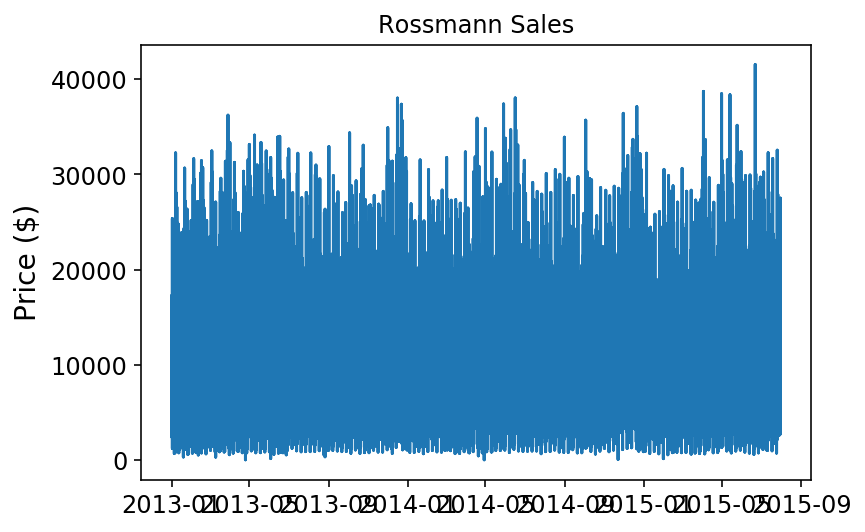

In [22]:
plt.plot(train.index, train['Sales'])
plt.title('Rossmann Sales')
plt.ylabel('Price ($)');
plt.show()

To clean up our graph, we want to form a new column which only accounts for the year of the sales. 

In [23]:
train['Year'] = train.index.year

# Take Dates from index and move to Date column 
train.reset_index(level=0, inplace = True)
train['sales'] = 0


Split the data into a train and test set. We use an 80/20 split. We then look to start are modein

In [24]:
train_store=train[0:675472] 
test_store=train[675472:]

In [25]:
train_store.Date = pd.to_datetime(train_store.Date, format="%Y-%m-%d")
train_store.index = train_store.Date
test_store.Date = pd.to_datetime(test_store.Date, format="%Y-%m-%d")
test_store.index = test_store.Date

train_store = train_store.resample('D').mean()
train_store = train_store.interpolate(method='linear')

test_store = test_store.resample('D').mean()
test_store = test_store.interpolate(method='linear')

C:\Users\notre\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


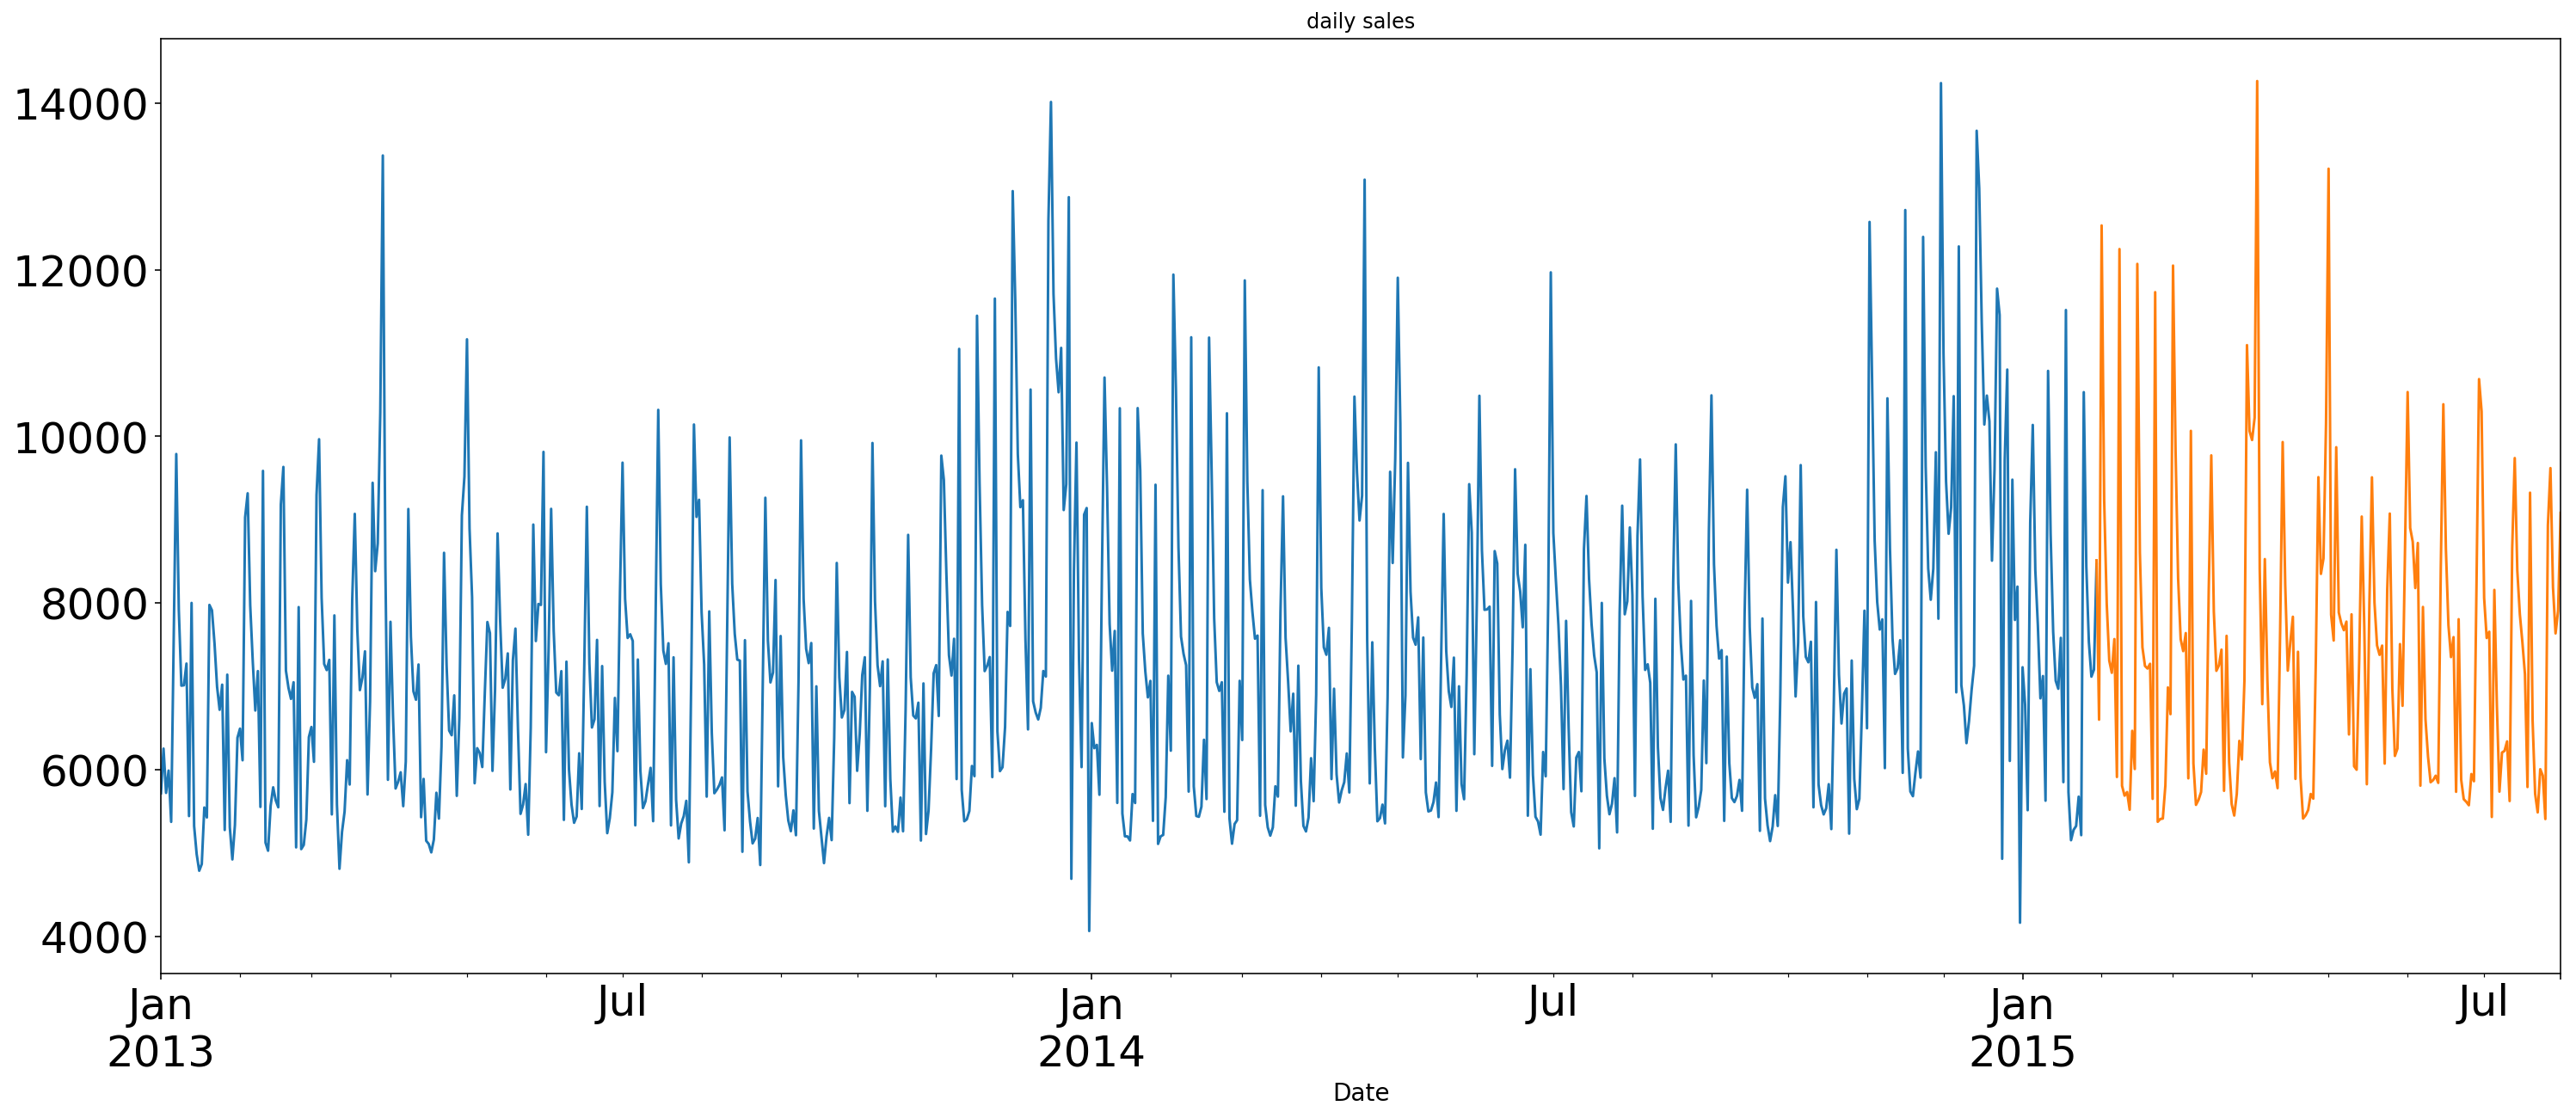

In [26]:
train_store.Sales.plot(figsize=(25,10), title='daily sales', fontsize=25)
test_store.Sales.plot()

Text(0.5,1,'Moving Average Forecast')

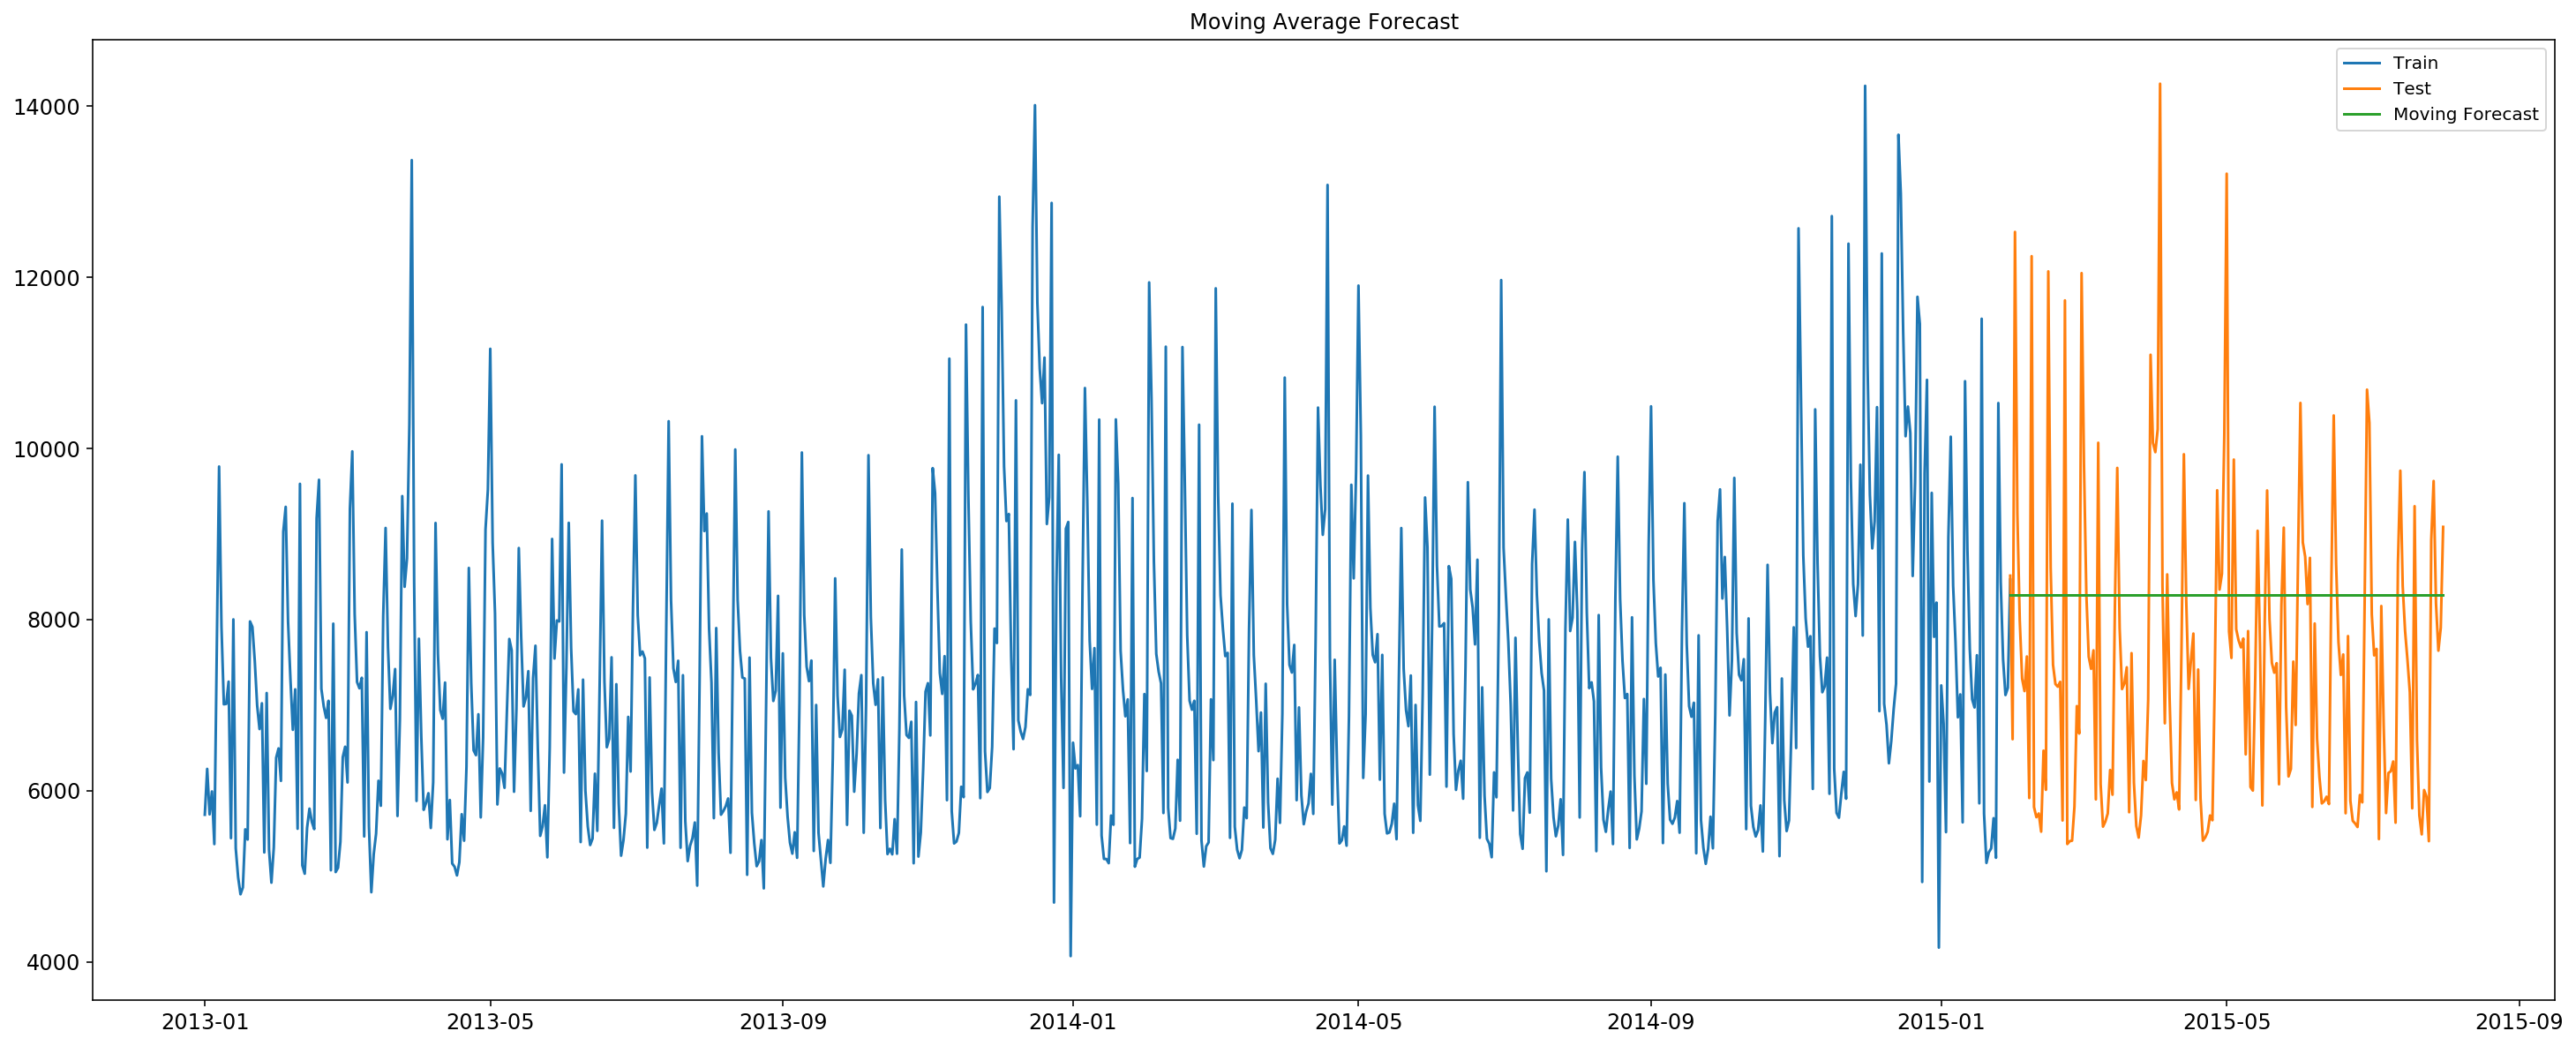

In [27]:
y_hat_avg_moving = test_store.copy()
y_hat_avg_moving['moving_avg_forcast'] = train_store.Sales.rolling(90).mean().iloc[-1]
plt.figure(figsize=(25,10))
plt.plot(train_store['Sales'], label='Train')
plt.plot(test_store['Sales'], label='Test')
plt.plot(y_hat_avg_moving['moving_avg_forcast'], label='Moving Forecast')
plt.legend(loc='best')
plt.title('Moving Average Forecast')

In [28]:
rms_avg_rolling = sqrt(mean_squared_error(test_store.Sales, y_hat_avg_moving.moving_avg_forcast))
print('ROLLING AVERAGE',rms_avg_rolling)

ROLLING AVERAGE 1915.886219620586


The rolling average for our model is 1,915.88. This prediction seems to be very consistent in hitting the average of the future sales. This naive model definitely looks like a solid model, however, it is not the best one. 

# Facebook Prophet Model

The Facebook Prophet package is designed to analyze time series data with daily observations, which can display patterns on different time scales. Prophet is optimized for business tasks with the following characteristics:

hourly, daily, or weekly observations with at least a few months (preferably a year) of history
strong multiple “human-scale” seasonalities: day of week and time of year
important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
a reasonable number of missing observations or large outliers
historical trend changes, for instance due to product launches or logging changes
trends that are non-linear growth curves, where a trend hits a natural limit or saturates
inspired by https://research.fb.com/prophet-forecasting-at-scale/

In [47]:
train = pd.read_csv("../rossmann-store-sales/train.csv", parse_dates = True, low_memory = False)

In [48]:
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].head()

train = train.dropna()

In [49]:
sales = train[train.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [51]:
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

In [52]:
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


In [55]:
# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
# default changpoint is 0.05, but you can change to 0.15 to control how sensitive the trend is
# higher changepoint = more sensitive
sales_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
sales_prophet.fit(sales)

If we find that our model is is fitting too closely to our training data (overfitting), our data will not be able to generalize new data.

If our model is not fitting closely enough to our training data (underfitting), our data has too much bias.

Underfitting: increase changepoint to allow more flexibility Overfitting: decrease changepoint to limit flexibili

In [56]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(sales)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    sales[changepoint] = future['yhat']

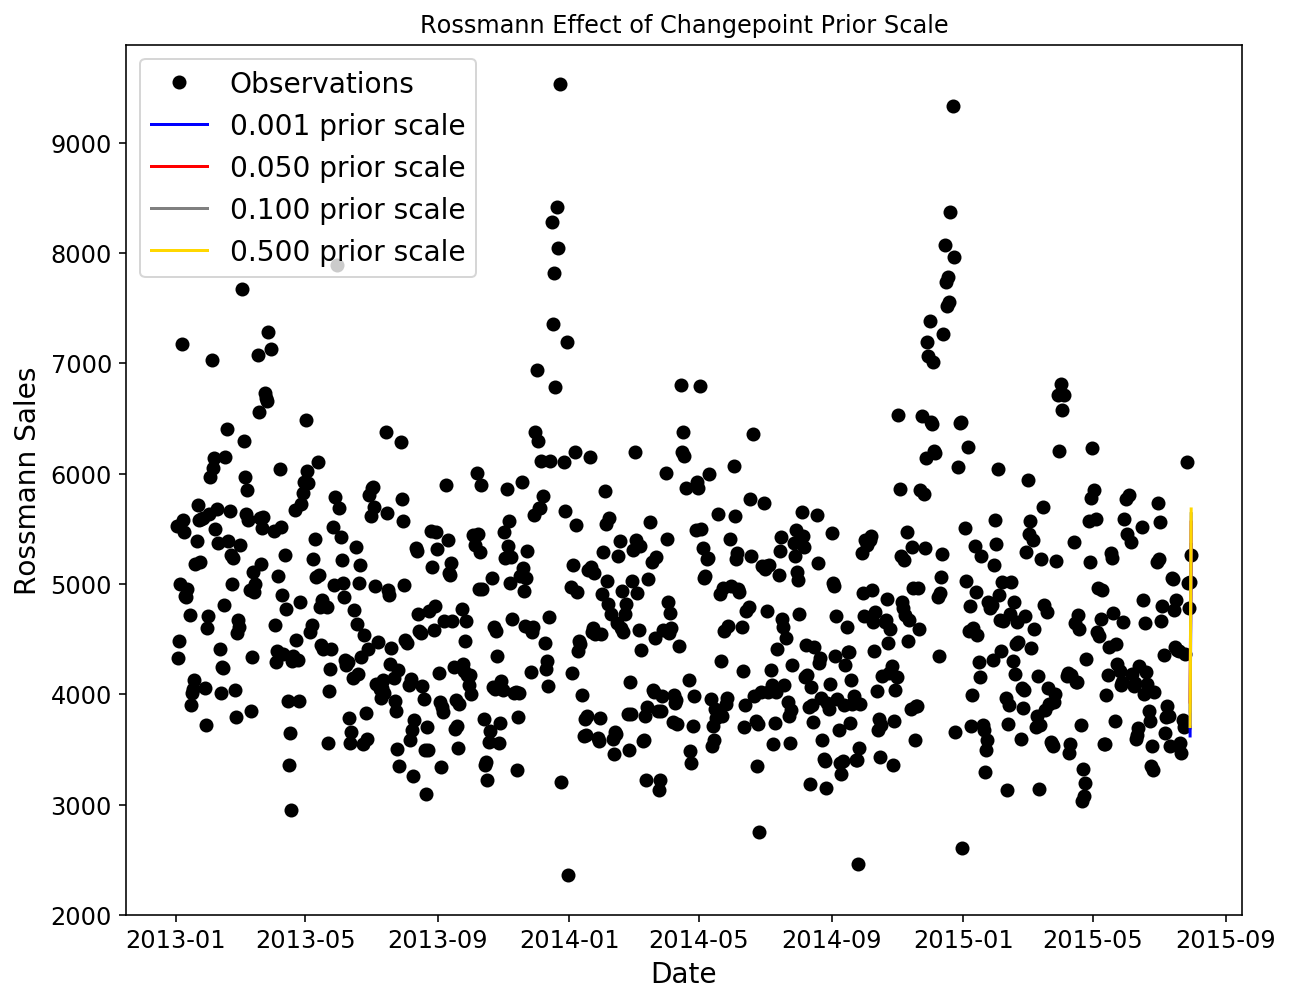

In [57]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(sales['ds'], sales['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(sales['ds'], sales[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Rossmann Sales'); plt.title('Rossmann Effect of Changepoint Prior Scale');

Predictions for 6 Weeks
In order to make forecasts, we need to create a future dataframe. We need to specify the amount of future periods to predict and the frequency of our prediction.

Periods: 6 Weeks Frequency: Daily

In [58]:
# Make a future dataframe for 6weeks
sales_forecast = sales_prophet.make_future_dataframe(periods=6*7, freq='D')
# Make predictions
sales_forecast = sales_prophet.predict(sales_forecast)

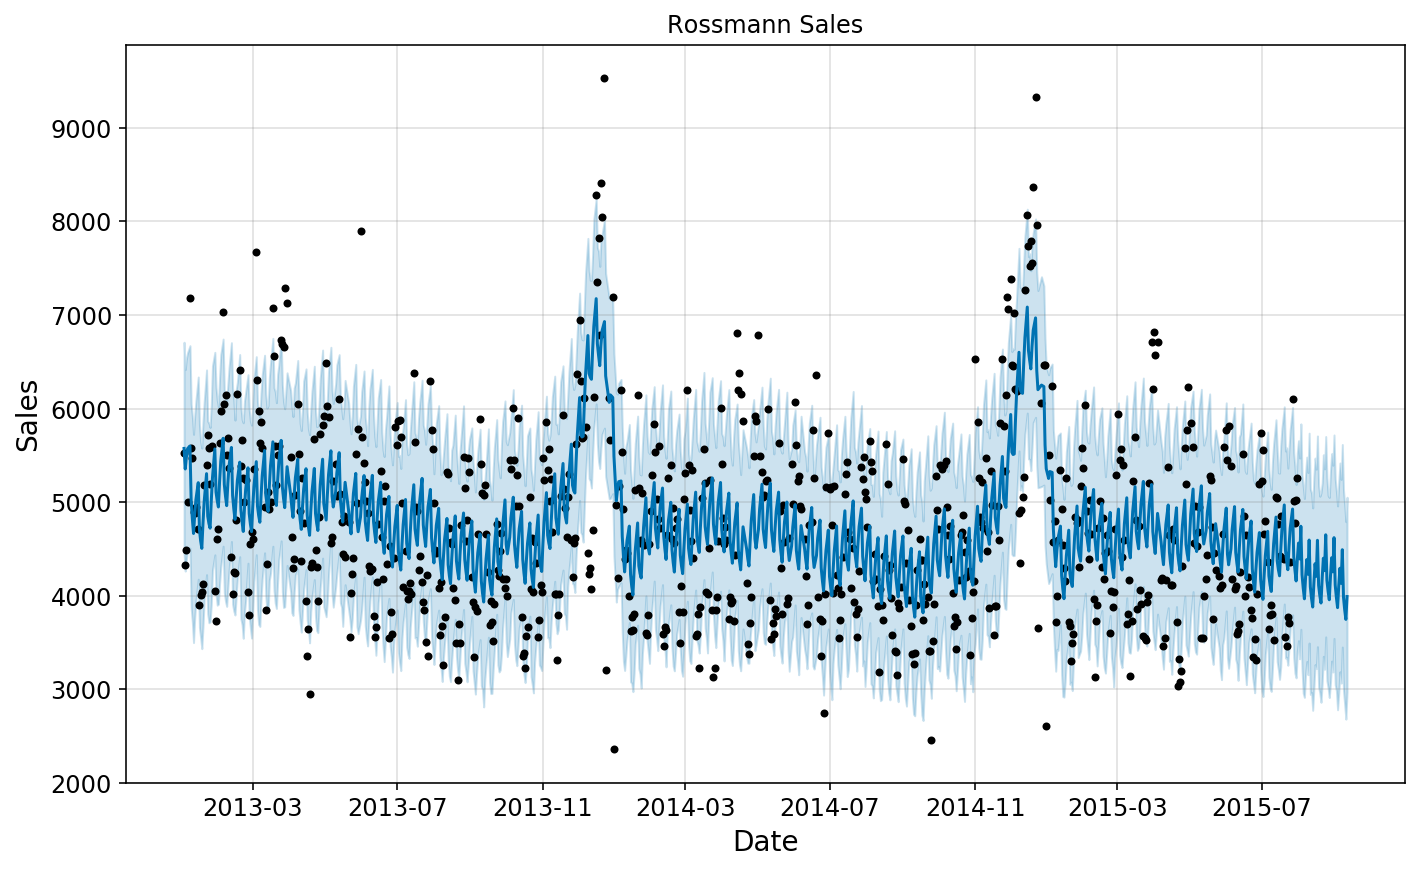

In [60]:
sales_prophet.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Rossmann Sales');

In [61]:
sales_prophet.changepoints[:10]

25    2013-01-31
50    2013-03-01
75    2013-04-02
100   2013-05-02
125   2013-06-04
150   2013-07-03
174   2013-07-31
199   2013-08-29
224   2013-09-27
249   2013-10-28
Name: ds, dtype: datetime64[ns]

We have listed out the most significant changepoints in our data. This is representing when the time series growth rate significantly changes.